In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [19]:
from models.backbone import Backbone, Joiner
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer
from models.odtr import ODTR

position_embedding = PositionEmbeddingSine(128, normalize=True)
backbone = Backbone('resnet50', False, False, False)
backbone = Joiner(backbone, position_embedding)
backbone.num_channels = 2048

transformer = Transformer(d_model=256, dropout=0.1, nhead=8,
                          dim_feedforward=2048,
                          num_encoder_layers=6,
                          num_decoder_layers=6,
                          normalize_before=False,
                          return_intermediate_dec=True)

model = ODTR(backbone, transformer, num_classes=2, num_queries=10, aux_loss=False)

model.eval()

/home/duypd/ThisPC-DuyPC/SG-Retrieval/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/duypd/ThisPC-DuyPC/SG-Retrieval/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ODTR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [20]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
          (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

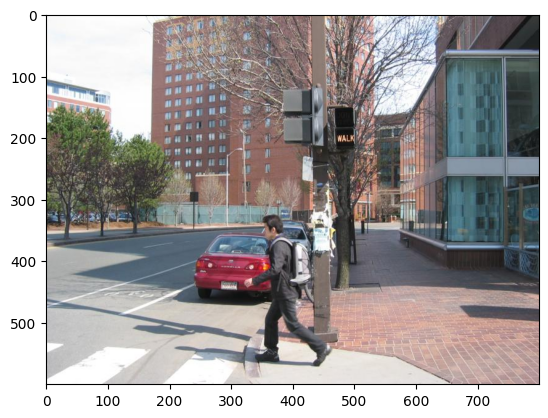

In [96]:
im_path = '/home/duypd/ThisPC-DuyPC/SG-Retrieval/Datasets/VisualGenome/VG_100K/2.jpg'
im = Image.open(im_path)
plt.imshow(im)
img = transform(im).unsqueeze(0)

In [97]:
outputs = model(img)

bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0], im.size)

print(f'Output keys: {outputs.keys()}')
print(f'pred_logits size: {outputs["pred_logits"][0].size()}')
print(f'pred_boxes size: {outputs["pred_boxes"][0].size()}')
print(f'pred_desc size: {outputs["pred_desc"][0].size()}')

Output keys: dict_keys(['pred_logits', 'pred_boxes', 'pred_desc'])
pred_logits size: torch.Size([10, 3])
pred_boxes size: torch.Size([10, 4])
pred_desc size: torch.Size([10, 7, 30522])


In [98]:
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]

keep = probas.max(-1).values > 0.0

keep_queries = torch.nonzero(keep, as_tuple=True)[0]

keep_queries

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [113]:
# save the attention weights
conv_features, dec_attn_weights = [], []
hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    )]

In [124]:
im_plot = np.array(im)
if(im_plot.shape[-1] == 4):
    im_plot = im_plot[..., :3]

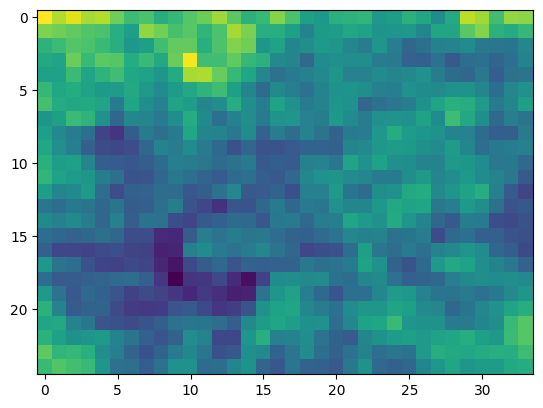

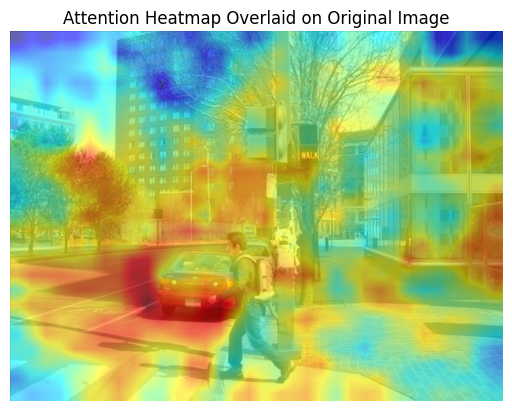

In [127]:
outputs = model(img)
    
x = dec_attn_weights[0]
attention_map = x[0,0].view(25, 34).cpu().detach().numpy()
plt.imshow(attention_map)
plt.show()

attention_map_resized = cv2.resize(attention_map, (im_plot.shape[1], im_plot.shape[0]))
attention_map_resized = (attention_map_resized - attention_map_resized.min()) / (attention_map_resized.max() - attention_map_resized.min())

heatmap_color = cv2.applyColorMap(np.uint8(255 * attention_map_resized), cv2.COLORMAP_JET)

alpha = 0.6  # Điều chỉnh mức độ trong suốt của heatmap
overlay_img = cv2.addWeighted(heatmap_color, alpha, im_plot, 1 - alpha, 0)
plt.imshow(overlay_img)
plt.title('Attention Heatmap Overlaid on Original Image')
plt.axis('off')
plt.show()



25 34
tensor(0)
tensor(1)
tensor(2)
tensor(3)
tensor(4)
tensor(5)
tensor(6)
tensor(7)
tensor(8)
tensor(9)


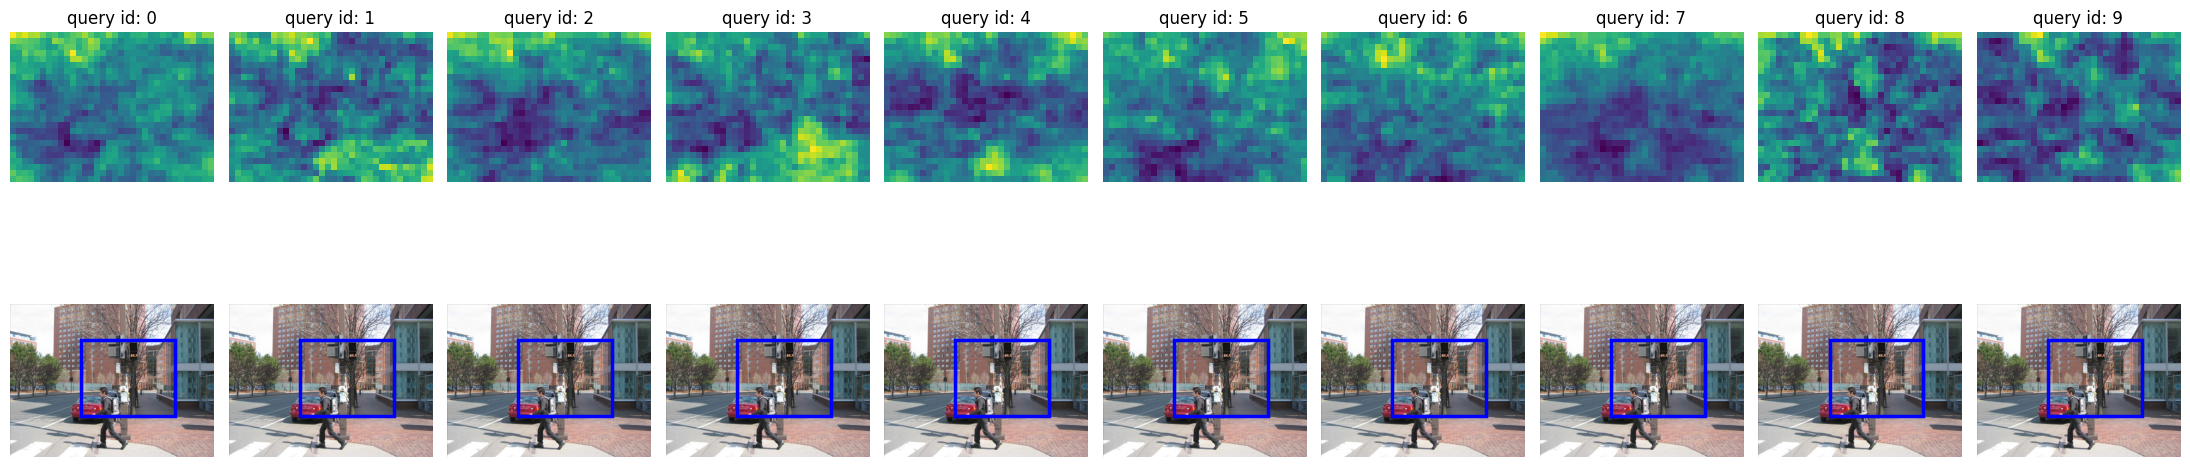

In [109]:
with torch.no_grad():
    # propagate through the model
    outputs = model(img)

    for hook in hooks:
        hook.remove()

    conv_features = conv_features[0]
    dec_attn_weights = dec_attn_weights[0]

    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]
    im_w, im_h = im.size
    print(h, w)

    fig, axs = plt.subplots(ncols=10, nrows=2, figsize=(22, 7))

    for idx, ax_i, (sxmin, symin, sxmax, symax) in \
            zip(keep_queries, axs.T, bboxes_scaled):
        print(idx)
        ax = ax_i[0]
        ax.imshow(dec_attn_weights[0, idx].view(h, w))
        ax.axis('off')
        ax.set_title(f'query id: {idx.item()}')
        ax = ax_i[1]
        ax.imshow(im)
        ax.add_patch(plt.Rectangle((sxmin, symin), sxmax - sxmin, symax - symin,
                                    fill=False, color='blue', linewidth=2.5))

        ax.axis('off')
    fig.tight_layout()
    plt.show() # show the output